<img src="http://www.di.uoa.gr/themes/corporate_lite/logo_el.png" title="Department of Informatics and Telecommunications - University of Athens"/>

---
# Data Mining - 3rd Project - Spring Semester 2020
---
# Offencive comments classification
---
## Student: 
> ##  - Nikoletos Konstantinos | sdi1700104

---

Import of essential **__libraries__**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys # only needed to determine Python version number
import matplotlib # only needed to determine Matplotlib version number
import wordcloud as wc
import collections
import seaborn as sbn
import nltk
import os
import collections
import itertools 
from scipy import sparse
from wordcloud import STOPWORDS,WordCloud
from pandas import DataFrame, read_csv
from nltk import word_tokenize, BigramCollocationFinder
from nltk.corpus import stopwords as stopwords2
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from sklearn import svm,metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB,CategoricalNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
import warnings
import string
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

---
---
# Reading __csv files__ / Forming __dataframes__ / Initial comments cleaning
---
---

In [7]:
# Opening data directory
directoryPath = r"C:\Users\nikol\Desktop\Data-Mining-Project3\data\\"
directoryData = os.listdir(directoryPath)

# Creating test dataframe
testpath = directoryPath+'impermium_verification_labels.csv'
testcsv = pd.read_csv(testpath)
test_df  = pd.DataFrame(data=testcsv)
testResults = test_df['Insult']
test_df.drop(columns=['Date','Usage','id'],inplace=True)
info_testDf = pd.DataFrame(columns = ['Insult','Comment','Clean comments','Comments with panctutation','POS_comment','Semantic_comment','fractionAdverbs','fractionVerbs','fractionAdjectives','fractionNouns'])
info_testDf['Insult'] =  testResults
info_testDf['Comment'] =  test_df['Comment']

# Creating train dataframe
trainpath = directoryPath+'train.csv'
traincsv = pd.read_csv(trainpath)
train_df  = pd.DataFrame(data=traincsv)
train_df.drop(columns=['Date'],inplace=True)
trainResults = train_df['Insult']
info_trainDf = pd.DataFrame(columns = ['Insult','Comment','Clean comments','POS_comment','Semantic_comment','fractionAdverbs','fractionVerbs','fractionAdjectives','fractionNouns'])
info_trainDf['Insult'] =  trainResults
info_trainDf['Comment'] =  train_df['Comment']

# Usefull functions

In [2]:
# Highligts the greater value in a dataframe column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkred' if v else '' for v in is_max]

In [3]:
# List of pancutation chars
punctuation = list(string.punctuation)

In [4]:
# Function that creates a confusion matrix
def create_ConfusionMatrix(confusionMatrix,title):
    classes = ['NEUTRAL','INSULT']
    cmap = plt.cm.Reds

    plt.imshow(confusionMatrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusionMatrix.max() / 2.
    for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
        plt.text(j, i, confusionMatrix[i, j],horizontalalignment="center",color="white" if confusionMatrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim([1.5, -.5])
    plt.show()  

# Stopwords set: consisted of a file from gitHub and nltk library

In [5]:
stopwordsPath = r"C:\Users\nikol\Desktop\Project-2-DataMining-\\english_stopwords.txt"
file = open(stopwordsPath,"r",errors='ignore')
stopwords_fromHub = [x.replace('\n',"") for x in file.readlines()]
stopwords = set(STOPWORDS)
stopwords_nltk =  set(stopwords2.words('english'))
stopwords.update(stopwords_nltk)
stopwords.update(set(stopwords_fromHub))


# __Pre-process and removal of links__


In [8]:
# Cleaning comment columns 
info_trainDf['Clean comments'] = train_df['Comment'].str.lower().replace(r'@\S+',' ',regex=True).replace(r'\\\S+',' ',regex=True).replace('\n',' ')
info_trainDf['Clean comments'] = info_trainDf['Clean comments'].str.replace('[{}]'.format(string.punctuation), '')

info_testDf['Clean comments'] = test_df['Comment'].str.lower().replace(r'@\S+',' ',regex=True).replace(r'\\\S+',' ',regex=True).replace('\n',' ')
info_testDf['Clean comments'] = info_testDf['Clean comments'].str.replace('[{}]'.format(string.punctuation), '')

In [9]:
info_testDf[['Comment','Clean comments']]

Comment  \
0                    "like this if you are a tribe fan"   
1                 "you're idiot......................."   
2     "I am a woman Babs, and the only "war on women...   
3     "WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...   
4     "haha green me red you now loser whos winning ...   
...                                                 ...   
2230  "FUCKIN LAME COME ON WTF STOP FUCKING OVER MY ...   
2231  "YOU SHUT YOUR IGNORANT PIE HOLE YOU LITTLE IN...   
2232  "sweetie pie is looking very much like her cou...   
2233  "ball4real where are you with your miami g-ayn...   
2234  "Man....if you are a 3 point shooter, you must...   

                                         Clean comments  
0                      like this if you are a tribe fan  
1                                           youre idiot  
2     i am a woman babs and the only war on women i ...  
3     wow  you benefitted so many wins this year fro...  
4     haha green me red you now loser whos winning n...  
...                                                 ...  
2230  fuckin lame come on wtf stop fucking over my b...  
2231  you shut your ignorant pie hole you little ins...  
2232  sweetie pie is looking very much like her cous...  
2233    ball4real where are you with your miami gayness  
2234  manif you are a 3 point shooter you must love ...  

[2235 rows x 2 columns]

In [10]:
info_trainDf[['Comment','Clean comments']]

Comment  \
0                                  "You fuck your dad."   
1     "i really don't understand your point.\xa0 It ...   
2     "A\\xc2\\xa0majority of Canadians can and has ...   
3     "listen if you dont wanna get married to a man...   
4     "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...   
...                                                 ...   
3942  "you are both morons and that is never happening"   
3943  "Many toolbars include spell check, like Yahoo...   
3944  "@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F...   
3945  "How about Felix? He is sure turning into one ...   
3946  "You're all upset, defending this hipster band...   

                                         Clean comments  
0                                     you fuck your dad  
1     i really dont understand your point  it seems ...  
2     a  of canadians can and has been wrong before ...  
3     listen if you dont wanna get married to a man ...  
4     c  b  xu    bi  t  2011 c    ho  kh     ng  d ...  
...                                                 ...  
3942    you are both morons and that is never happening  
3943  many toolbars include spell check like yahoo f...  
3944    falls sd i told my boy he should call around...  
3945  how about felix he is sure turning into one he...  
3946  youre all upset defending this hipster bandand...  

[3947 rows x 2 columns]

---
---
#  Naive Bayes
---
---

Usefull functions:

In [11]:
# Vectorizes train and test
def vectorizeData(train,test,vectorizer):
    train = vectorizer.fit_transform(train)
    test = vectorizer.transform(test)
    return train,test

In [12]:
def naiveBayes(train,trainLabels,test,testLabels):
    count_train,count_test = vectorizeData(train,test,CountVectorizer())
    count_train = count_train.toarray()
    count_test = count_test.toarray()
    naiveBayes = GaussianNB()
    naiveBayes.fit(count_train,trainLabels)
    prediction = naiveBayes.predict(count_test)
    ac_score = metrics.accuracy_score(testResults,prediction)
    f1_score = metrics.f1_score(testResults,prediction)
    print('ACCURACY: ' + '{:.3%}'.format(ac_score))
    print('F1: ' + '{:.3%}'.format(f1_score))
    cm = sklearn.metrics.confusion_matrix(testResults,prediction,labels=[0,1])
    create_ConfusionMatrix(cm,title='Confusion matrix')
    return ac_score,f1_score

In [13]:
# Dataframe for results
resultDataframe = pd.DataFrame(columns=['Pre-process','F1_Score','Accuracy'])

# __> Pre-process level 1: Links and pancutation__
Comments are in the initial state but without pancutation and links , etc 

ACCURACY: 52.349%
F1: 52.561%


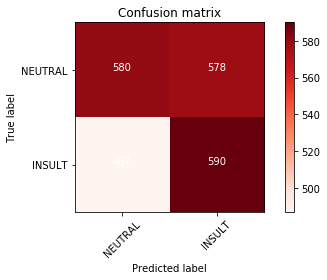

In [14]:
ac_score,f1_score = naiveBayes(info_trainDf['Clean comments'],trainResults,info_testDf['Clean comments'],testResults)
resultDataframe = resultDataframe.append([{'Pre-process':'Pancutation/Links','Accuracy':ac_score,'F1_Score':f1_score}],ignore_index=True)

# Remarks:
We see a small score because there has not been a carefull cleaning in comments

# __> Pre-process level 2: Lemmatization__

In [15]:
# Function that lemmatizes wanted columns
lemmatizer = nltk.stem.WordNetLemmatizer()
def Lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(y,'v') for y in word_tokenize(text)])

In [16]:
lemmatized_test = info_testDf['Clean comments'].apply(Lemmatize)
lemmatized_train = info_trainDf['Clean comments'].apply(Lemmatize)

In [17]:
info_trainDf['Lemmatized Comments'] = lemmatized_train
info_testDf['Lemmatized Comments'] = lemmatized_test
info_trainDf[['Clean comments','Lemmatized Comments']]

Clean comments  \
0                                     you fuck your dad   
1     i really dont understand your point  it seems ...   
2     a  of canadians can and has been wrong before ...   
3     listen if you dont wanna get married to a man ...   
4     c  b  xu    bi  t  2011 c    ho  kh     ng  d ...   
...                                                 ...   
3942    you are both morons and that is never happening   
3943  many toolbars include spell check like yahoo f...   
3944    falls sd i told my boy he should call around...   
3945  how about felix he is sure turning into one he...   
3946  youre all upset defending this hipster bandand...   

                                    Lemmatized Comments  
0                                     you fuck your dad  
1     i really dont understand your point it seem th...  
2     a of canadians can and have be wrong before no...  
3     listen if you dont wan na get marry to a man o...  
4     c b xu bi t 2011 c ho kh ng d ng cu chi nh c h...  
...                                                 ...  
3942        you be both morons and that be never happen  
3943  many toolbars include spell check like yahoo f...  
3944  fall sd i tell my boy he should call around to...  
3945  how about felix he be sure turn into one hell ...  
3946  youre all upset defend this hipster bandand be...  

[3947 rows x 2 columns]

ACCURACY: 51.096%
F1: 53.350%


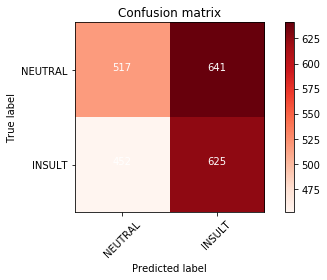

In [18]:
ac_score,f1_score = naiveBayes(lemmatized_train,trainResults,lemmatized_test,testResults)
resultDataframe = resultDataframe.append([{'Pre-process':'Lemmatazation','Accuracy':ac_score,'F1_Score':f1_score}],ignore_index=True)

# Remarks
Accuracy has dicreased but f1 is greater than the initial simple cleaning of comments 

# __> Pre-process level 3: Stop words removal__

In [19]:
# Removes stopwords from sentences
def removeStopWords(text):
    return ' '.join([y for y in word_tokenize(text) if y not in stopwords])

In [20]:
stopwords_test = info_testDf['Clean comments'].apply(removeStopWords)
stopwords_train = info_trainDf['Clean comments'].apply(removeStopWords)
info_trainDf['Without stopwords'] = stopwords_train
info_testDf['Without stopwords'] = stopwords_test
info_testDf[['Clean comments','Without stopwords']]

Clean comments  \
0                      like this if you are a tribe fan   
1                                           youre idiot   
2     i am a woman babs and the only war on women i ...   
3     wow  you benefitted so many wins this year fro...   
4     haha green me red you now loser whos winning n...   
...                                                 ...   
2230  fuckin lame come on wtf stop fucking over my b...   
2231  you shut your ignorant pie hole you little ins...   
2232  sweetie pie is looking very much like her cous...   
2233    ball4real where are you with your miami gayness   
2234  manif you are a 3 point shooter you must love ...   

                                      Without stopwords  
0                                             tribe fan  
1                                                 idiot  
2     woman babs war women coming jackazzes protecti...  
3                   wow benefitted wins bat nice stupid  
4                    haha green red loser winning moron  
...                                                 ...  
2230                  fuckin lame wtf fucking bity shit  
2231        shut ignorant pie hole insignificunt insect  
2232  sweetie pie cousin maggie ewhat beauty islove ...  
2233                            ball4real miami gayness  
2234             manif 3 shooter love playing wade bron  

[2235 rows x 2 columns]

ACCURACY: 52.438%
F1: 53.803%


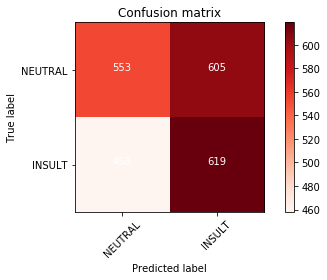

In [21]:
ac_score,f1_score = naiveBayes(stopwords_train,trainResults,stopwords_test,testResults)
resultDataframe = resultDataframe.append([{'Pre-process':'Stop words removal','Accuracy':ac_score,'F1_Score':f1_score}],ignore_index=True)

# Remarks
We notice that removing stopwords is the best pre-process so far and this happens because many repeated words with no importance have been removed

# __> Pre-process level 4: Bigramms__

ACCURACY: 56.107%
F1: 53.263%


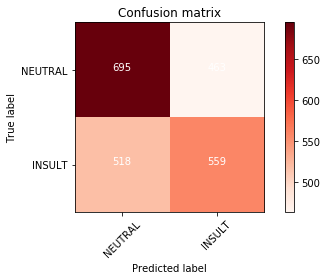

In [22]:
# Initial variables with test and train comments
bigram_test = info_testDf['Clean comments']
bigram_train = info_trainDf['Clean comments']

# CounteVectorizer using bigramms
bigramVectorizer = CountVectorizer(ngram_range=(2,2))
count_train = bigramVectorizer.fit_transform(bigram_train)
count_test = bigramVectorizer.transform(bigram_test)

# Change sparce arrays to numpy arrays
count_train = count_train.toarray()
count_test = count_test.toarray()

# Gaussian Classification
naiveBayes = GaussianNB()
naiveBayes.fit(count_train,trainResults)
prediction = naiveBayes.predict(count_test)

# Adding scores to result dataframe
ac_score = metrics.accuracy_score(testResults,prediction)
f1_score = metrics.f1_score(testResults,prediction)

# Result represantation
print('ACCURACY: ' + '{:.3%}'.format(ac_score))
print('F1: ' + '{:.3%}'.format(f1_score))
cm = sklearn.metrics.confusion_matrix(testResults,prediction,labels=[0,1])
create_ConfusionMatrix(cm,title='Confusion matrix')
resultDataframe = resultDataframe.append([{'Pre-process':'Bigramms','Accuracy':ac_score,'F1_Score':f1_score}],ignore_index=True)

# Remarks
Accuracy increased and so did f1. By using bigramms, classification catches sequential words that may be used often insultive

# __> Pre-process level 5: Laplace Smoothing using MultinomialNB__

ACCURACY: 68.233%
F1: 61.746%


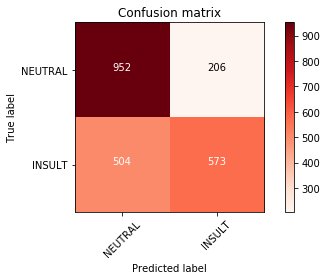

In [23]:
# Initial variables with test and train comments
laplace_test = info_testDf['Clean comments']
laplace_train = info_trainDf['Clean comments']

# CounteVectorizer
count_train,count_test = vectorizeData(laplace_train,laplace_test,CountVectorizer())
count_train = count_train.toarray()
count_test = count_test.toarray()

# Laplace smoothing -> MultinomialNB
naiveBayes = MultinomialNB(alpha=1.0)
naiveBayes.fit(count_train,trainResults)
prediction = naiveBayes.predict(count_test)

# Adding scores to result dataframe
ac_score = metrics.accuracy_score(testResults,prediction)
f1_score = metrics.f1_score(testResults,prediction)
resultDataframe = resultDataframe.append([{'Pre-process':'Laplace Smoothing - MultinomialNB','Accuracy':ac_score,'F1_Score':f1_score}],ignore_index=True)
print('ACCURACY: ' + '{:.3%}'.format(ac_score))
print('F1: ' + '{:.3%}'.format(f1_score))
cm = sklearn.metrics.confusion_matrix(testResults,prediction,labels=[0,1])
create_ConfusionMatrix(cm,title='Confusion matrix')    

# Remarks
The best scores so far. This happens because of Laplace Smoothing, which solves the problem of zero probability 

# > Final results presentation

In [24]:
resultDataframe.style.format("{:.3%}",subset=['Accuracy','F1_Score']).apply(highlight_max,subset=['Accuracy','F1_Score']).hide_index()

# Final remarks
I noticed that every change has increased initial score, but text process didn't make any exceptional difference as by using another classifier with an hyperparameter

---
---
# TFI-DF / POS tagging
---
---

In this section we are going to test POS tagging combined with Tfidf Vectorizer.


In [25]:
# Returns a list of [(word,tag),...] for a given string
def pos_preprocess(text):
    return nltk.pos_tag(nltk.word_tokenize(text))

In [26]:
# Function that returns a dictionary of wanted tags frequency per comment 
wantedtags = set(['RB','VB','JJ','NN'])
def findFrequency(pos_tags):
    size = len(pos_tags)
    counter = collections.Counter([tag for word,tag in pos_tags if tag in wantedtags])
    tagDict = {'RB':0,'VB':0,'JJ':0,'NN':0}
    for (key,value) in zip(counter.keys(),counter.values()):
        tagDict[key]+=value
    if size!=0:
        for (key,value) in zip(tagDict.keys(),tagDict.values()):
            tagDict[key]/=size
    return tagDict

In [27]:
def insertFractions(df,postagsList):
    df['fractionAdverbs'] = postagsList['RB']
    df['fractionVerbs'] = postagsList['VB']
    df['fractionNouns'] = postagsList['NN']
    df['fractionAdjectives'] = postagsList['JJ']

In [28]:
# Result dataframe
pos_tfidf_results = pd.DataFrame()

# POS tags finding frequency
Function that makes the wanted classification,prints accuracy/f1 and a confusion matrix

In [29]:
def classify(classifier,test,train):
    classifier.fit(train,trainResults)
    prediction = classifier.predict(test)
    print('ACCURACY: ' + '{:.3%}'.format(metrics.accuracy_score(testResults,prediction)))
    print('F1: ' + '{:.3%}'.format(metrics.f1_score(testResults,prediction)))
    cm = sklearn.metrics.confusion_matrix(testResults,prediction,labels=[0,1])
    create_ConfusionMatrix(cm,title='Confusion matrix')
    return metrics.accuracy_score(testResults,prediction),metrics.f1_score(testResults,prediction)

# Counting frequencies

In [30]:
def countFrequencies(df,column):
    postagsList = {'RB':[],'VB':[],'JJ':[],'NN':[]}
    for comment in df[column]:
        comm = findFrequency(pos_preprocess(comment))
        for (key,value) in zip(comm.keys(),comm.values()):
            postagsList[key].append(value)
    insertFractions(df,postagsList)

In [31]:
countFrequencies(info_trainDf,'Clean comments')
countFrequencies(info_testDf,'Clean comments')

# Vectorazation

In [32]:
tfidfVectorizer = TfidfVectorizer()
tfidf_train = tfidfVectorizer.fit_transform(info_trainDf['Clean comments'])
tfidf_test = tfidfVectorizer.transform(info_testDf['Clean comments'])

# Classifications without frequencies

ACCURACY: 62.640%
F1: 41.731%


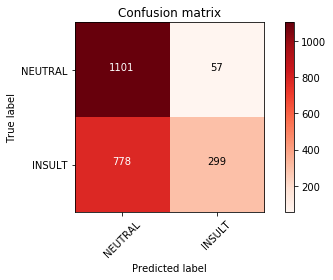

In [33]:
# Random forest classification
ac,f1 = classify(RandomForestClassifier(),tfidf_test,tfidf_train)
pos_tfidf_results = pos_tfidf_results.append([{'Classifier':'RandomForest without POS','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 69.485%
F1: 61.294%


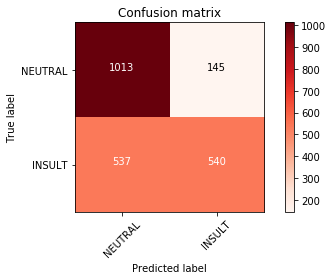

In [34]:
# SVM
ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),tfidf_test,tfidf_train)
pos_tfidf_results = pos_tfidf_results.append([{'Classifier':'SVM without POS','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks (without POS tags):
- Random Forest: Low f1 score but increased accuracy score in contrast with measurements from the previous query
- SVM: Used these parameters because I saw that were the best. Nice scores

# Concatenating frequencies to tfidf array

In [35]:
nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()

# Inserts frequencies of wanted tags to tfidf sparce array
def contacFrequencies_toArray(df,tfidf_nparray):
    frequencyList = ['fractionAdverbs','fractionVerbs','fractionNouns','fractionAdjectives']
    for freq in frequencyList:
        list_as_nparray = np.asarray(df[freq])
        list_as_nparray = np.vstack(list_as_nparray)
        final = np.hstack((tfidf_nparray,list_as_nparray))

    return sparse.csr_matrix(final)

sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

ACCURACY: 61.745%
F1: 39.661%


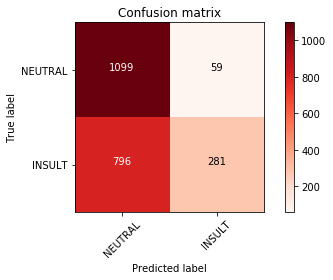

In [36]:
# Random forest
ac,f1 = classify(RandomForestClassifier(),sptest,sptrain)
pos_tfidf_results = pos_tfidf_results.append([{'Classifier':'RandomForest','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 69.709%
F1: 61.600%


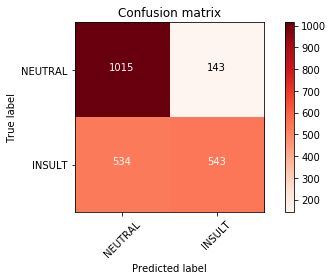

In [37]:
# SVM
ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),sptest,sptrain)
pos_tfidf_results = pos_tfidf_results.append([{'Classifier':'SVM','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks (with POS tags):
- Random Forest: Scores have been dicreased 
- SVM: Both scores have been increased but it is a very small increase

# > Final results of TFIDF combined with POS tagging <

In [38]:
pos_tfidf_results.style.format("{:.3%}",subset=['Accuracy','F1']).apply(highlight_max,subset=['Accuracy','F1']).hide_index()

---
---
# Optimal classification
---
---

# Data exploration

In this part I am going to show some WordClouds and try to understand better the data and find the classifiers or processing that need to be done in order to achieve better accuracy and scores

# WordClouds

By plotting WordClouds I am going to find out, the most frequent words and the differences between INSULT and NON-INSULT comments  

In [39]:
# Function that given a list of data will produce a WordCloud
def generate_WordCloud(data,stopwords):
    textWords = []
    for x in data:
        for y in word_tokenize(x) :
            y = y.lower()
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
                
    counter = collections.Counter(textWords)
    words = WordCloud(background_color ='white',stopwords=stopwords,margin=0).generate_from_frequencies(frequencies=dict(counter))

    plt.figure(figsize=(20,10))
    plt.imshow(words,interpolation='bilinear')
    plt.axis("off")
    plt.show()

WordCloud from the initial cleaning.Comments are in their initial form,without links and unicodes

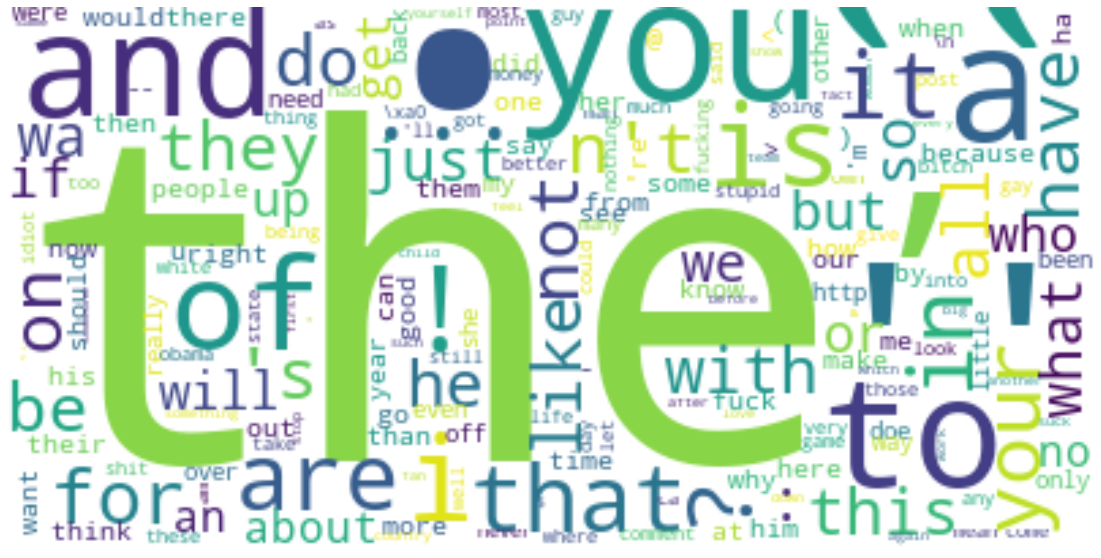

In [48]:
generate_WordCloud(info_trainDf['Comment'],stopwords)

Comparison of wordclouds, from the comments that marked as insult and in the next wordcloud ,from the comments that are not insultive

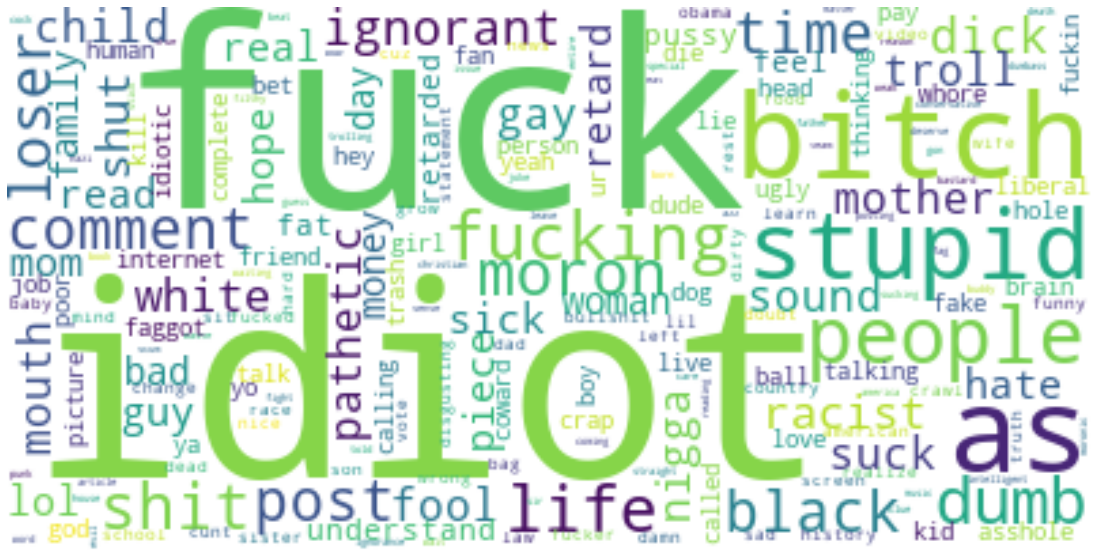

In [60]:
temp = info_trainDf.loc[info_trainDf['Insult'] == 1]
generate_WordCloud(temp['Without stopwords'],stopwords)

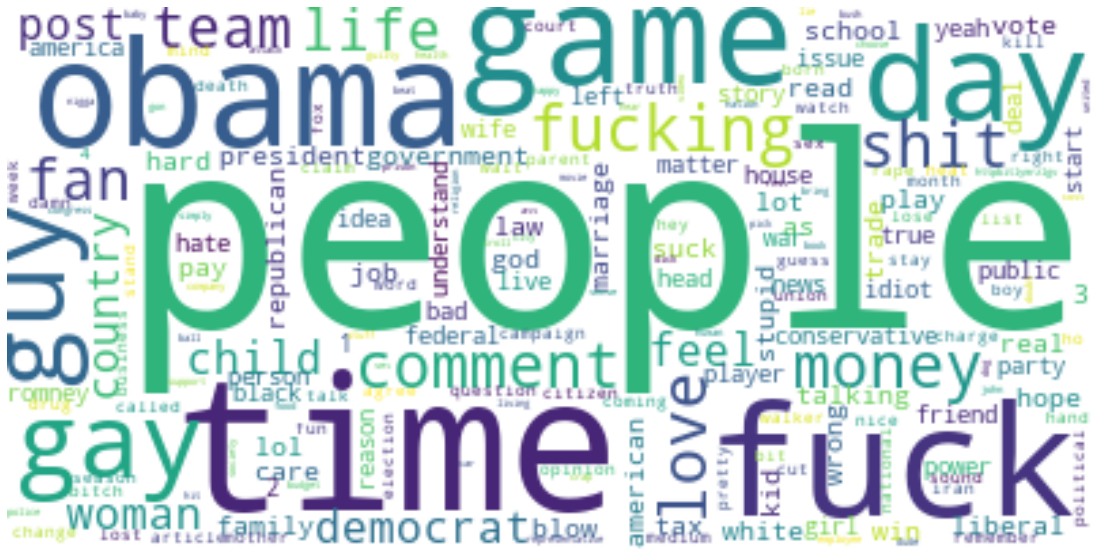

In [62]:
temp = info_trainDf.loc[info_trainDf['Insult'] == 0]
generate_WordCloud(temp['Without stopwords'],stopwords)

# Remarks from WordClouds:
- From these word clouds we understand that there are a lot of insulting words even to comments that are not marked as insults, which makes classification even harder


---
# Comments cleaning

An even better cleaning of comments

In [40]:
import unicodedata
import re
import string

def normalazation(text):
    return ' '.join([normalize_word(y) for y in word_tokenize(text)])

def normalize_word(word):
    # Will remove the encode token by token
    word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def smallwordsRemoval(text):
    return ' '.join([remove_smallWords(y) for y in word_tokenize(text)])

def remove_smallWords(word):
    if (len(word) > 2):
        return word
    else:
        return ''

Creating columns to test if pancutaion can help

In [41]:
# Creating a column with cleaned comments except from pancutation train
info_trainDf['Comments with pancutation'] = info_trainDf['Comment']
info_trainDf['Comments with pancutation'] = info_trainDf['Comments with pancutation'].str.lower().replace(r'@\S+',' ',regex=True).replace(r'\\\S+',' ',regex=True).replace('\n',' ')
info_trainDf['Comments with pancutation'] = info_trainDf['Comments with pancutation'].apply(Lemmatize)
info_trainDf['Comments with pancutation'] = info_trainDf['Comments with pancutation'].apply(removeStopWords)

# Creating a column with cleaned comments except from pancutation test
info_testDf['Comments with pancutation'] = info_testDf['Comment']
info_testDf['Comments with pancutation'] = info_testDf['Comments with pancutation'].str.lower().replace(r'@\S+',' ',regex=True).replace(r'\\\S+',' ',regex=True).replace('\n',' ')
info_testDf['Comments with pancutation'] = info_testDf['Comments with pancutation'].apply(Lemmatize)
info_testDf['Comments with pancutation'] = info_testDf['Comments with pancutation'].apply(removeStopWords)

In [42]:
def cleanText(df,column_toSave):
    df[column_toSave] = df['Comment']
    df[column_toSave] = df[column_toSave].str.lower().replace(r'@\S+',' ',regex=True).replace(r'\\\S+',' ',regex=True).replace('\n',' ')
    df[column_toSave] = df[column_toSave].str.replace('[{}]'.format(string.punctuation), '')
    df[column_toSave] = df[column_toSave].apply(smallwordsRemoval)
    df[column_toSave] = df[column_toSave].apply(Lemmatize)
    df[column_toSave] = df[column_toSave].apply(removeStopWords)
    df[column_toSave] = df[column_toSave].apply(normalazation)

cleanText(info_testDf,'Best-Clean Comments')
cleanText(info_trainDf,'Best-Clean Comments')

In [48]:
# Dataframe to save all tries scores
alltriesdf = pd.DataFrame()

WordCloud from the column of the best cleaned comments

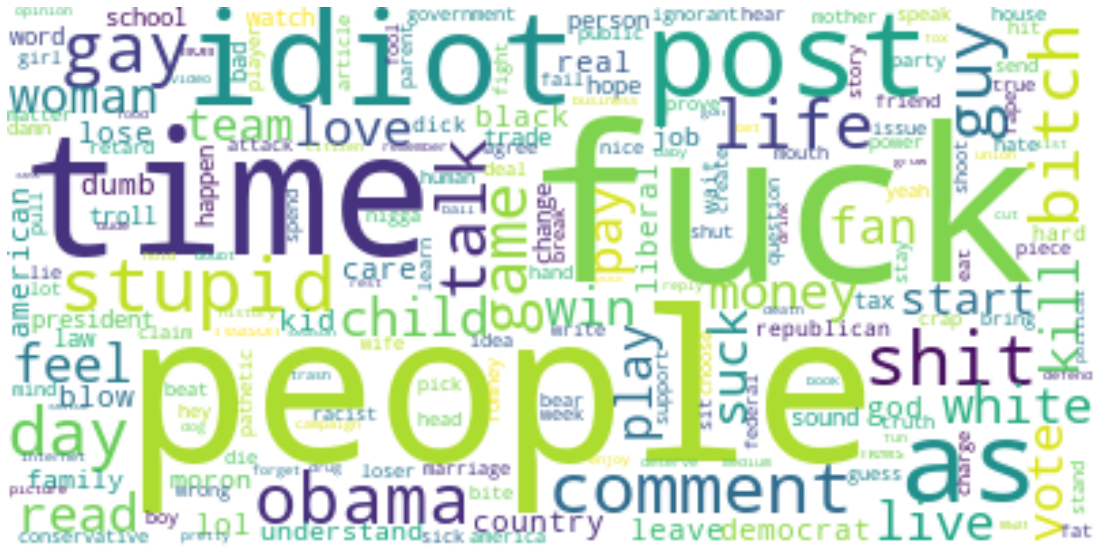

In [69]:
generate_WordCloud(info_trainDf['Best-Clean Comments'],stopwords)

---
# __1st try :__ 
As in previous query but with cleaner comments

ACCURACY: 70.067%
F1: 62.010%


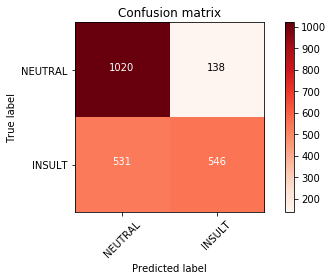

In [49]:
countFrequencies(info_trainDf,'Best-Clean Comments')
countFrequencies(info_testDf,'Best-Clean Comments')

nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()

sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'TfidfVectorizer','Comment pre-process':'Best-Clean Comments','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 64.743%
F1: 47.745%


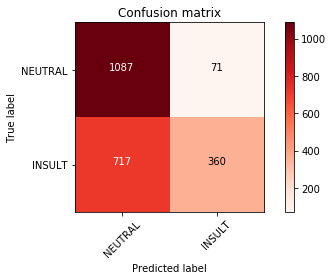

In [50]:
ac,f1 = classify(MultinomialNB(alpha=0.1),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'TfidfVectorizer','Comment pre-process':'Best-Clean Comments','Paremeters':'alpha=0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks:
With cleaner comments we have better results


---
# __2nd try :__ 
As in previous query but with cleaner comments and with CountVectorizer

ACCURACY: 69.530%
F1: 60.522%


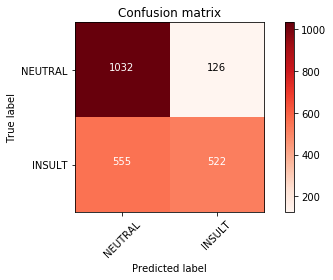

In [51]:
countFrequencies(info_trainDf,'Best-Clean Comments')
countFrequencies(info_testDf,'Best-Clean Comments')

tfidf_train,tfidf_test = vectorizeData(info_trainDf['Best-Clean Comments'],info_testDf['Best-Clean Comments'],CountVectorizer())

nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()

sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'CountVectorizer','Comment pre-process':'Best-Clean Comments','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 68.412%
F1: 63.382%


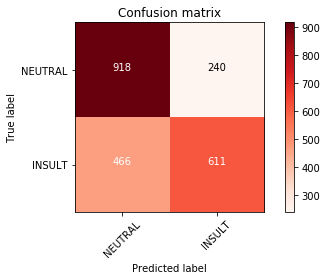

In [52]:
ac,f1 = classify(MultinomialNB(alpha=0.1),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Best-Clean Comments','Paremeters':'alpha=0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

With Laplace Smoothing

ACCURACY: 67.964%
F1: 58.178%


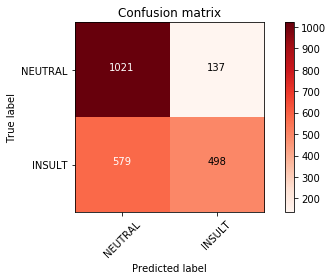

In [53]:
ac,f1 = classify(MultinomialNB(alpha=1),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Best-Clean Comments','Paremeters':'alpha=1 (Laplace smoothing)','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks:
Slighly better scores , with a better cleanning and with the frequencies of pos tags

In [54]:
alltriesdf.style.format("{:.3%}",subset=['Accuracy','F1']).apply(highlight_max,subset=['Accuracy','F1']).hide_index()

---
# Semantic analysis

I am using this method to find the class of every sentence and add it to the classification 

__sentiment_analysis__: Function that produses a new sentence of classes for every comment

In [55]:
import empath
from empath import Empath

def semantic_analysis(df,column):
    # Empath is a lexicon that connects every word with a class of words that belongs to
    lexicon = Empath()
    semantic = []
    count = 0

    # adding to the lexicon a new catgory to mark inapropriate words    
    lexicon.create_category('bad_words',['fuck,fck,morron,idiot','black','white','nigga','gay','bitch','dick','cock','shit','dumb','fool','loser','suck','shut'])

    # Analyze every word from given column
    for comment in df[column]:
        d = lexicon.analyze(comment, normalize=False)
        x = []
        for key, value in d.items():
            x.append(value)
        x = np.asarray(x)
        semantic.append(x)

    df['Semantic_comment'] = semantic
    categories = []
    a = lexicon.analyze("")
    for key, value in a.items():
        categories.append(key)

    # Creating a column from the class of each word in comments
    sem = []
    for i in range(df.shape[0]):
        a = []
        for j in range(len(semantic[0])):
            for k in range(int(semantic[i][j])):
                a.append(categories[j])
        b = " ".join(a)
        sem.append(b)
    df['Semantic_comment']  = sem

Creating a column in dataframe that is going to have semantic classes and not words

In [56]:
semantic_analysis(info_testDf,'Clean comments')
semantic_analysis(info_trainDf,'Clean comments')

["dick", "ass", "fucking", "bitch", "shit", "fuck", "prick", "fuck", "cunt", "pussy", "asshole", "slut", "fucked", "fucking", "whore", "damn", "dumbass", "shit", "nigga", "fucking", "jerk", "stupid", "dude", "cause", "dick", "dumb", "suck", "damn", "chick", "swear", "nasty", "bitch", "Bitch", "damn", "bastard", "penis", "nut", "hell", "fag", "fucker", "screw", "tramp", "punk", "balls", "pussy", "dicks", "Karma", "dick", "thug", "freak", "bull", "ugly", "hoe", "crazy", "little_shit", "damn", "perv", "right", "big_dick", "skank", "butthole", "white_girl", "arse", "kid", "fuckin", "motherfucker", "bet", "dumb_ass", "bitches", "guy", "Fuck", "little_bitch", "dirty", "boobs", "dickhead", "bad_ass", "girl", "faggot", "jackass", "booty", "suck", "fat", "douche", "vagina", "dick", "butt", "dildo"]
["dick", "ass", "fucking", "bitch", "shit", "fuck", "prick", "fuck", "cunt", "pussy", "asshole", "slut", "fucked", "fucking", "whore", "damn", "dumbass", "shit", "nigga", "fucking", "jerk", "stupid",

WordCloud produced from the classes of each word. These classes came from __Semantic Analysis__

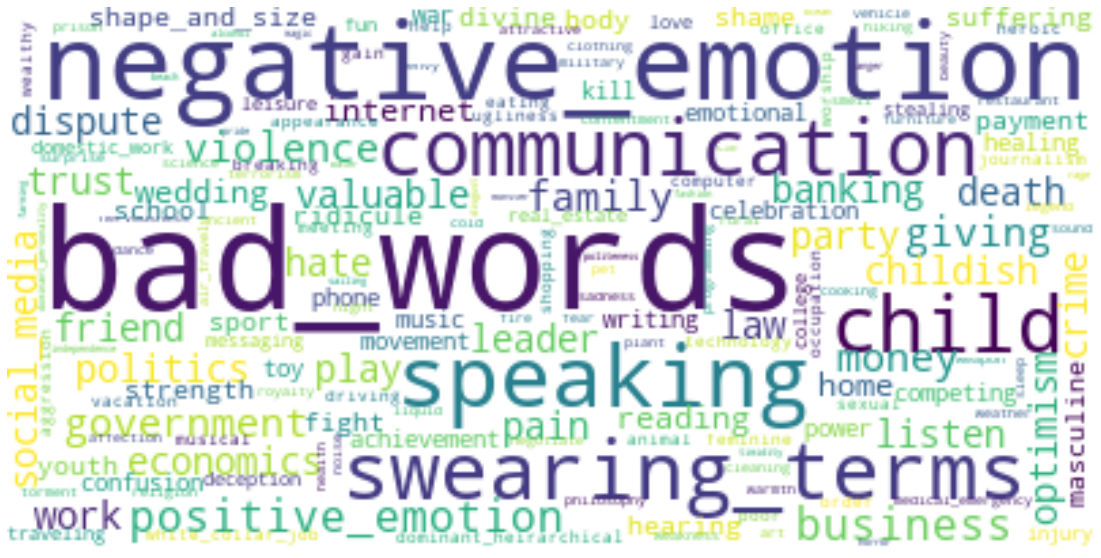

In [76]:
generate_WordCloud(info_trainDf['Semantic_comment'],stopwords)

# Dataframes of train and test so far
# Train

In [57]:
info_trainDf

Insult                                            Comment  \
0          1                               "You fuck your dad."   
1          0  "i really don't understand your point.\xa0 It ...   
2          0  "A\\xc2\\xa0majority of Canadians can and has ...   
3          0  "listen if you dont wanna get married to a man...   
4          0  "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...   
...      ...                                                ...   
3942       1  "you are both morons and that is never happening"   
3943       0  "Many toolbars include spell check, like Yahoo...   
3944       0  "@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F...   
3945       0  "How about Felix? He is sure turning into one ...   
3946       0  "You're all upset, defending this hipster band...   

                                         Clean comments POS_comment  \
0                                     you fuck your dad         NaN   
1     i really dont understand your point  it seems ...         NaN   
2     a  of canadians can and has been wrong before ...         NaN   
3     listen if you dont wanna get married to a man ...         NaN   
4     c  b  xu    bi  t  2011 c    ho  kh     ng  d ...         NaN   
...                                                 ...         ...   
3942    you are both morons and that is never happening         NaN   
3943  many toolbars include spell check like yahoo f...         NaN   
3944    falls sd i told my boy he should call around...         NaN   
3945  how about felix he is sure turning into one he...         NaN   
3946  youre all upset defending this hipster bandand...         NaN   

                                       Semantic_comment  fractionAdverbs  \
0         family swearing_terms home children bad_words         0.000000   
1                                communication speaking         0.000000   
2     help wedding hate aggression family family cri...         0.052632   
3     wedding wedding family family vacation masculi...         0.000000   
4                                                               0.000000   
...                                                 ...              ...   
3942                                                            0.000000   
3943  help magic reading communication strength writing         0.285714   
3944  masculine masculine play optimism communicatio...         0.000000   
3945  money wedding swearing_terms noise hearing pho...         0.000000   
3946  domestic_work occupation blue_collar_job ridic...         0.105263   

      fractionVerbs  fractionAdjectives  fractionNouns  \
0          0.000000            0.000000       1.000000   
1          0.000000            0.250000       0.250000   
2          0.052632            0.263158       0.526316   
3          0.000000            0.411765       0.235294   
4          0.000000            0.000000       0.875000   
...             ...                 ...            ...   
3942       0.000000            0.000000       0.000000   
3943       0.142857            0.000000       0.142857   
3944       0.000000            0.000000       0.600000   
3945       0.000000            0.142857       0.857143   
3946       0.000000            0.105263       0.526316   

                                    Lemmatized Comments  \
0                                     you fuck your dad   
1     i really dont understand your point it seem th...   
2     a of canadians can and have be wrong before no...   
3     listen if you dont wan na get marry to a man o...   
4     c b xu bi t 2011 c ho kh ng d ng cu chi nh c h...   
...                                                 ...   
3942        you be both morons and that be never happen   
3943  many toolbars include spell check like yahoo f...   
3944  fall sd i tell my boy he should call around to...   
3945  how about felix he be sure turn into one hell ...   
3946  youre all upset defend this hipster bandand be...   

                             

# Test

In [58]:
info_testDf

Insult                                            Comment  \
0          0                 "like this if you are a tribe fan"   
1          1              "you're idiot......................."   
2          1  "I am a woman Babs, and the only "war on women...   
3          1  "WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...   
4          1  "haha green me red you now loser whos winning ...   
...      ...                                                ...   
2230       0  "FUCKIN LAME COME ON WTF STOP FUCKING OVER MY ...   
2231       1  "YOU SHUT YOUR IGNORANT PIE HOLE YOU LITTLE IN...   
2232       0  "sweetie pie is looking very much like her cou...   
2233       1  "ball4real where are you with your miami g-ayn...   
2234       0  "Man....if you are a 3 point shooter, you must...   

                                         Clean comments  \
0                      like this if you are a tribe fan   
1                                           youre idiot   
2     i am a woman babs and the only war on women i ...   
3     wow  you benefitted so many wins this year fro...   
4     haha green me red you now loser whos winning n...   
...                                                 ...   
2230  fuckin lame come on wtf stop fucking over my b...   
2231  you shut your ignorant pie hole you little ins...   
2232  sweetie pie is looking very much like her cous...   
2233    ball4real where are you with your miami gayness   
2234  manif you are a 3 point shooter you must love ...   

     Comments with panctutation POS_comment  \
0                           NaN         NaN   
1                           NaN         NaN   
2                           NaN         NaN   
3                           NaN         NaN   
4                           NaN         NaN   
...                         ...         ...   
2230                        NaN         NaN   
2231                        NaN         NaN   
2232                        NaN         NaN   
2233                        NaN         NaN   
2234                        NaN         NaN   

                                       Semantic_comment  fractionAdverbs  \
0             social_media legend dominant_heirarchical              0.0   
1                                                                    0.0   
2     help family business death fight war appearanc...              0.0   
3     ridicule surprise politeness animal negative_e...              0.0   
4             swearing_terms play competing achievement              0.0   
...                                                 ...              ...   
2230  swearing_terms driving party negative_emotion ...              0.0   
2231    childish cooking eating shape_and_size children              0.0   
2232  family attractive attractive childish cooking ...              0.0   
2233                                                                 0.0   
2234  play optimism sports swimming love toy listen ...              0.0   

      fractionVerbs  fractionAdjectives  fractionNouns  \
0               0.0            0.000000       1.000000   
1               0.0            0.000000       1.000000   
2               0.0            0.100000       0.500000   
3               0.0            0.500000       0.500000   
4               0.0            0.333333       0.666667   
...             ...                 ...            ...   
2230            0.0            0.500000       0.500000   
2231            0.0            0.166667       0.833333   
2232            0.0            0.125000       0.625000   
2233            0.0            0.000000       1.000000   
2234            0.0            0.000000       0.833333   

                                    Lemmatized Comments  \
0                       like this if you be a tribe fan   
1                                           youre idiot   
2     i be a woman babs and the only war on women i ...   
3     wow you benefit so many win this year from his...   
4     haha green me re

---
# __3rd try :__ 
With clean comments (not the best-clean comments)

ACCURACY: 70.738%
F1: 64.725%


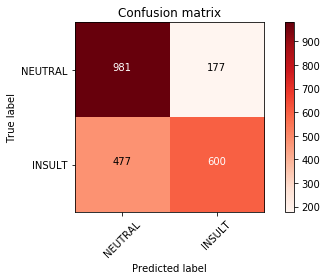

In [59]:
tfidf_train,tfidf_test = vectorizeData(info_trainDf['Clean comments'],info_testDf['Clean comments'],CountVectorizer())

nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()

sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 64.295%
F1: 65.214%


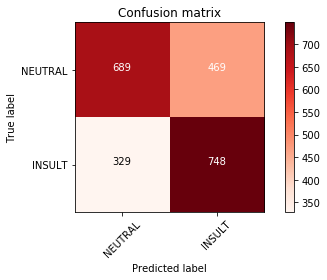

In [81]:
ac,f1 = classify(MultinomialNB(alpha=0.1),sptest,sptrain)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments','Paremeters':'alpha = 0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks:
Not so much difference between the best cleaning an the initial and more simple clean

---
# __4rth try:__ 
Using semantics in concat with vectorized comments

ACCURACY: 71.007%
F1: 64.973%


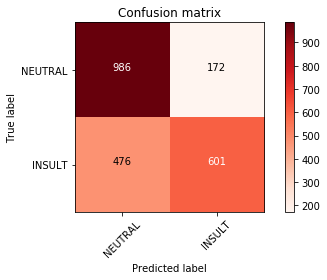

In [60]:
tfidf_train,tfidf_test = vectorizeData(info_trainDf['Clean comments'],info_testDf['Clean comments'],CountVectorizer())

nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()

sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

sen_train,sen_test = vectorizeData(info_trainDf['Semantic_comment'],info_testDf['Semantic_comment'],CountVectorizer())

sen_train  = sen_train.toarray()
sen_test  = sen_test.toarray()

convat_train = sparse.csr_matrix(np.hstack((sptrain.toarray(),sen_train)))
concat_test  = sparse.csr_matrix(np.hstack((sptest.toarray(),sen_test)))

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),tfidf_test,tfidf_train)
alltriesdf = alltriesdf.append([{'Classifier':'SVM','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + Semantic_comment','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 64.519%
F1: 65.204%


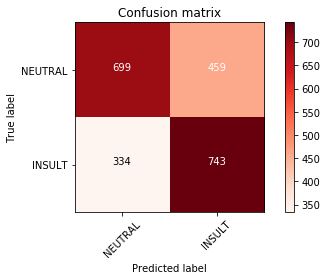

In [61]:
ac,f1 = classify(MultinomialNB(alpha=0.1),tfidf_test,tfidf_train)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + Semantic_comment','Paremeters':'alpha = 0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

---
# POS tagging
As in the previous query but making indepentend columns from every words tag

In [62]:
# This function concatenates a comment with the tags prodused and makes a new column only from the tags 
def addPosTags(listOfText):
    pos_tags_column = []
    pos_tags_only = []
    for text in listOfText:
        pos_tags_list = []
        doc = pos_preprocess(text)
        for token in doc:
            pos_tags_list.append(token[1])
        all_pos_tags = ' '.join(pos_tags_list)
        pos_tags_only.append(all_pos_tags)
        newtxt = text + ' ' + all_pos_tags
        pos_tags_column.append(newtxt)
    return pos_tags_column,pos_tags_only

info_trainDf['POS_comment'],info_trainDf['POS_tags'] = addPosTags(info_trainDf['Clean comments'])
info_testDf['POS_comment'],info_testDf['POS_tags'] = addPosTags(info_testDf['Clean comments'])

# Train

In [63]:
info_trainDf

Insult                                            Comment  \
0          1                               "You fuck your dad."   
1          0  "i really don't understand your point.\xa0 It ...   
2          0  "A\\xc2\\xa0majority of Canadians can and has ...   
3          0  "listen if you dont wanna get married to a man...   
4          0  "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...   
...      ...                                                ...   
3942       1  "you are both morons and that is never happening"   
3943       0  "Many toolbars include spell check, like Yahoo...   
3944       0  "@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F...   
3945       0  "How about Felix? He is sure turning into one ...   
3946       0  "You're all upset, defending this hipster band...   

                                         Clean comments  \
0                                     you fuck your dad   
1     i really dont understand your point  it seems ...   
2     a  of canadians can and has been wrong before ...   
3     listen if you dont wanna get married to a man ...   
4     c  b  xu    bi  t  2011 c    ho  kh     ng  d ...   
...                                                 ...   
3942    you are both morons and that is never happening   
3943  many toolbars include spell check like yahoo f...   
3944    falls sd i told my boy he should call around...   
3945  how about felix he is sure turning into one he...   
3946  youre all upset defending this hipster bandand...   

                                            POS_comment  \
0                     you fuck your dad PRP VBP PRP$ NN   
1     i really dont understand your point  it seems ...   
2     a  of canadians can and has been wrong before ...   
3     listen if you dont wanna get married to a man ...   
4     c  b  xu    bi  t  2011 c    ho  kh     ng  d ...   
...                                                 ...   
3942  you are both morons and that is never happenin...   
3943  many toolbars include spell check like yahoo f...   
3944    falls sd i told my boy he should call around...   
3945  how about felix he is sure turning into one he...   
3946  youre all upset defending this hipster bandand...   

                                       Semantic_comment  fractionAdverbs  \
0         family swearing_terms home children bad_words         0.000000   
1                                communication speaking         0.000000   
2     help wedding hate aggression family family cri...         0.052632   
3     wedding wedding family family vacation masculi...         0.000000   
4                                                               0.000000   
...                                                 ...              ...   
3942                                                            0.000000   
3943  help magic reading communication strength writing         0.285714   
3944  masculine masculine play optimism communicatio...         0.000000   
3945  money wedding swearing_terms noise hearing pho...         0.000000   
3946  domestic_work occupation blue_collar_job ridic...         0.105263   

      fractionVerbs  fractionAdjectives  fractionNouns  \
0          0.000000            0.000000       1.000000   
1          0.000000            0.250000       0.250000   
2          0.052632            0.263158       0.526316   
3          0.000000            0.411765       0.235294   
4          0.000000            0.000000       0.875000   
...             ...                 ...            ...   
3942       0.000000            0.000000       0.000000   
3943       0.142857            0.000000       0.142857   
3944       0.000000            0.000000       0.600000   
3945       0.000000            0.142857       0.857143   
3946       0.000000            0.105263       0.526316   

                                    Lemmatized Comments  \
0                                     you fuck your dad   
1     i really dont understand your point it seem th...

---
# 5th try : 
POS taggs frequencies + concated matrices of vectorized comments and POS taggs + Semantic comments

ACCURACY: 71.141%
F1: 65.710%


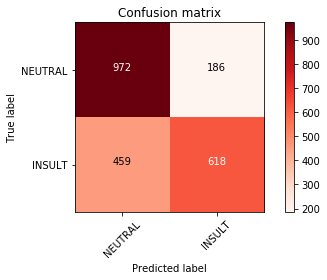

In [64]:
tfidf_train,tfidf_test = vectorizeData(info_trainDf['Clean comments'],info_testDf['Clean comments'],CountVectorizer())

# ----------- Vectorizing comments ------------ #
nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()
sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

# ----------- Vectorizing semantics column ------------ #
sen_train,sen_test = vectorizeData(info_trainDf['Semantic_comment'],info_testDf['Semantic_comment'],CountVectorizer())
sen_train  = sen_train.toarray()
sen_test  = sen_test.toarray()
# Concatinating sparce arrays
convat_train = np.hstack((sptrain.toarray(),sen_train))
concat_test  = np.hstack((sptest.toarray(),sen_test))

# ----------- Vectorizing POS tags column ------------ #
pos_train,pos_test = vectorizeData(info_trainDf['POS_tags'],info_testDf['POS_tags'],CountVectorizer())
pos_train  = pos_train.toarray()
pos_test  = pos_test.toarray()
# Concatinating sparce arrays
posconvat_train = np.hstack((sptrain.toarray(),pos_train))
posconcat_test  = np.hstack((sptest.toarray(),pos_test))

# ----------- Concatinating sparce arrays to one ------------ #
final_test = sparse.csr_matrix(np.hstack((concat_test,posconcat_test)))
final_train = sparse.csr_matrix(np.hstack((convat_train,posconvat_train)))

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),final_test,final_train)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + POS_tags + Semantics','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 61.342%
F1: 65.357%


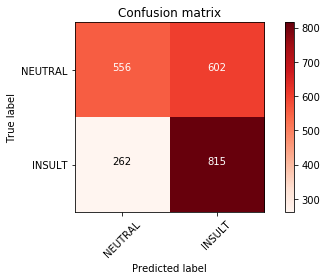

In [65]:
ac,f1 = classify(MultinomialNB(alpha=0.1),final_test,final_train)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + POS_tags + Semantics','Paremeters':'alpha = 0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

---
# Sentiment Analysis
# Valence Aware Dictionary and sEntiment Reasoner - __VADER__
> VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative. 

Function that creates a new column of pos/neg/neu depending on every word

In [68]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def VaderperWord(text):
    newlist = []
    vader = SentimentIntensityAnalyzer()
    for word in word_tokenize(text):
        vresult = vader.polarity_scores(word)
        resultmax = max(vresult,key= lambda x : vresult[x])
        newlist.append(resultmax)
         
    return ' '.join([y for y in newlist])

In [69]:
# Train
info_trainDf['Vader sentences'] = info_trainDf['Clean comments']
info_trainDf['Vader sentences'] = info_trainDf['Vader sentences'].apply(VaderperWord)

# Test
info_testDf['Vader sentences'] = info_testDf['Clean comments']
info_testDf['Vader sentences'] = info_testDf['Vader sentences'].apply(VaderperWord)

For example:

In [70]:
info_trainDf[['Vader sentences']]

Vader sentences
0                                       neu neg neu neu
1     neg neu neu neu neu neu neu neu neu neu neu ne...
2     neg neu neu neu neu neu neu neg neu neu neu ne...
3     neu neu neu neu neu neu neu neu neu neg neu ne...
4     neg neg neu neu neg neu neg neu neu neu neg ne...
...                                                 ...
3942                neu neu neu neg neu neu neu neu neu
3943  neu neu neu neu neu pos neu neu neu neu neu po...
3944  neu neu neg neu neu neu neu neu neu neu neu ne...
3945  neu neu neu neu neu pos neu neu neu neg neu ne...
3946  neu neu neg neu neu neu neu neu neu neu neu ne...

[3947 rows x 1 columns]

---
# 6th try : 
Vader vectorized arrays + concatenated matrices of vectorized comments 

ACCURACY: 71.588%
F1: 65.842%


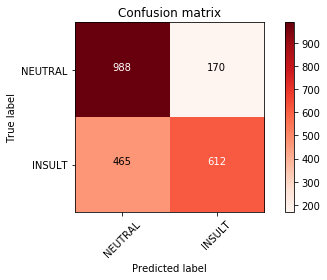

In [71]:
# Vectorizing initial comments and concating pos frequencies
tfidf_train,tfidf_test = vectorizeData(info_trainDf['Clean comments'],info_testDf['Clean comments'],CountVectorizer())
nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()
sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

# Vader sentences conqatenation
sen_train,sen_test = vectorizeData(info_trainDf['Vader sentences'],info_testDf['Vader sentences'],CountVectorizer())
sen_train  = sen_train.toarray()
sen_test  = sen_test.toarray()

# Concatenation
convat_train = sparse.csr_matrix(np.hstack((sptrain.toarray(),sen_train)))
concat_test  = sparse.csr_matrix(np.hstack((sptest.toarray(),sen_test)))

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),concat_test,convat_train)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + Vader','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 65.145%
F1: 65.668%


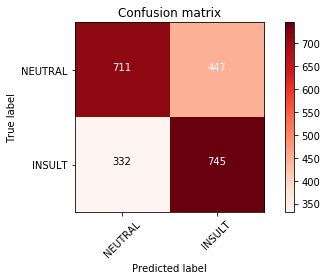

In [72]:
ac,f1 = classify(MultinomialNB(alpha=0.1),concat_test,convat_train)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer','Comment pre-process':'Clean comments + Vader','Paremeters':'alpha = 0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks:
Small changes that surprises. It will be investigated in the end

---
# 7th try : 
POS taggs frequencies + concated matrices of vectorized comments and POS taggs + Semantic comments

ACCURACY: 71.767%
F1: 64.847%


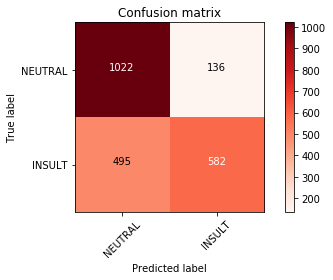

In [75]:
# Comments vectorazation
tfidf_train,tfidf_test = vectorizeData(info_trainDf['Clean comments'],info_testDf['Clean comments'],CountVectorizer(ngram_range=(2,2)))
nptfidf_train  = tfidf_train.toarray()
nptfidf_test  = tfidf_test.toarray()
sptest = contacFrequencies_toArray(info_testDf,nptfidf_test)
sptrain = contacFrequencies_toArray(info_trainDf,nptfidf_train)

# Semantic vectorazation
sen_train,sen_test = vectorizeData(info_trainDf['Semantic_comment'],info_testDf['Semantic_comment'],CountVectorizer(ngram_range=(2,2)))
sen_train  = sen_train.toarray()
sen_test  = sen_test.toarray()

# POS taggs
pos_train,pos_test = vectorizeData(info_trainDf['POS_tags'],info_testDf['POS_tags'],CountVectorizer(ngram_range=(2,2)))
pos_train  = pos_train.toarray()
pos_test  = pos_test.toarray()

# Vader
vader_train,vader_test = vectorizeData(info_trainDf['Vader sentences'],info_testDf['Vader sentences'],CountVectorizer(ngram_range=(2,2)))
vader_train  = vader_train.toarray()
vader_test  = vader_test.toarray()

# Final concatenation
final_test = sparse.csr_matrix(np.hstack((sptest.toarray(),posconcat_test,vader_test,sen_test)))
final_train = sparse.csr_matrix(np.hstack((sptrain.toarray(),posconvat_train,vader_train,sen_train)))

ac,f1 = classify(svm.SVC(C=1,gamma=1,kernel='linear'),final_test,final_train)
alltriesdf = alltriesdf.append([{'Classifier':'SVC','Vectorizer':'CountVectorizer with bigramms','Comment pre-process':'Clean comments + POS_tags + Vader + Semantics','Paremeters':'C=1,gamma=1,kernel=linear','Accuracy':ac,'F1':f1}],ignore_index=True)

ACCURACY: 65.951%
F1: 66.133%


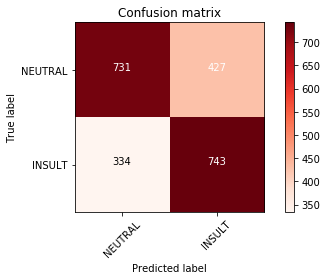

In [76]:
ac,f1 = classify(MultinomialNB(alpha=0.1),final_test,final_train)
alltriesdf = alltriesdf.append([{'Classifier':'MultinomialNB','Vectorizer':'CountVectorizer with bigramms','Comment pre-process':'Clean comments + POS_tags + Vader + Semantics','Paremeters':'alpha = 0.1','Accuracy':ac,'F1':f1}],ignore_index=True)

# Remarks:
My best try so far but no big changes to scores

---
# 8th try : GridSearchCV
POS taggs frequencies + concated matrices of vectorized comments and POS taggs + Semantic comments

ACCURACY: 70.828%
F1: 61.737%


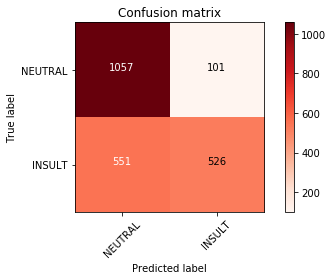

In [79]:
param_grid = {'C': [0.1, 1 ,10], 
              'gamma': [1, 0.1 ,10],
              'kernel': ['rbf','linear']}  

grid = GridSearchCV(svm.SVC(),param_grid,refit=True)
# fitting the model for grid search 
grid.fit(final_train, trainResults)
grid_predictions = grid.predict(final_test)

print('ACCURACY: ' + '{:.3%}'.format(metrics.accuracy_score(testResults,grid_predictions)))
print('F1: ' + '{:.3%}'.format(metrics.f1_score(testResults,grid_predictions)))
cm = sklearn.metrics.confusion_matrix(testResults,grid_predictions,labels=[0,1])
create_ConfusionMatrix(cm,title='Confusion matrix')

---
# > Final results <
---
These are my tries to achieve a better score .Didn't have the time to test a little bit more because of another project that I have. I'm sure that I could use more wisely the above feautures but I cann't spend more time

In [88]:
alltriesdf.style.format("{:.3%}",subset=['Accuracy','F1']).apply(highlight_max,subset=['Accuracy','F1']).hide_index()

# ** Reasearch for Vader
I was surprised that Vader didn't work as I expected, so I searched a litle my data and Vader to find out what's going wrong

In [80]:
def vader(column):
    vader = SentimentIntensityAnalyzer()
    vaderResults = []
    vaderCompound = []
    for sent in column:
        result = vader.polarity_scores(sent)
        vaderCompound.append(result['compound'])
        del result['compound']
        resultmax = max(result,key= lambda x : result[x])
        vaderResults.append(resultmax)
    return vaderResults,vaderCompound

info_trainDf['VADER'],info_trainDf['VADER_Compound'] = vader(info_trainDf['Clean comments'])
info_testDf['VADER'],info_testDf['VADER_Compound'] = vader(info_testDf['Clean comments'])

In [81]:
temp = info_trainDf[['Insult','VADER','Comment']]
temp.groupby(['Insult','VADER']).count()

Comment
Insult VADER         
0      neg         86
       neu       2723
       pos         89
1      neg        172
       neu        870
       pos          7

In [82]:
temp = info_testDf[['Insult','VADER_Compound','Comment','VADER']]
temp.groupby(['Insult','VADER']).agg({'VADER_Compound':'mean','Comment':'count'})

VADER_Compound  Comment
Insult VADER                         
0      neg         -0.593784       69
       neu         -0.008683      998
       pos          0.609357       91
1      neg         -0.624092      170
       neu         -0.250255      878
       pos          0.563900       29

In [83]:
temp = info_testDf[['Insult','VADER','Comment']]
temp.groupby(['Insult','VADER']).count()

Comment
Insult VADER         
0      neg         69
       neu        998
       pos         91
1      neg        170
       neu        878
       pos         29

In [84]:
temp = info_trainDf[['Insult','VADER_Compound','Comment','VADER']]
temp.groupby(['Insult','VADER']).agg({'VADER_Compound':'mean','Comment':'count'})

VADER_Compound  Comment
Insult VADER                         
0      neg         -0.570959       86
       neu         -0.010595     2723
       pos          0.630896       89
1      neg         -0.689978      172
       neu         -0.338253      870
       pos          0.458300        7

In [85]:
temp = info_testDf[['Insult','VADER_Compound','Comment','VADER']]
temp.groupby(['Insult','VADER']).agg({'VADER_Compound':'mean','Comment':'count'})

VADER_Compound  Comment
Insult VADER                         
0      neg         -0.593784       69
       neu         -0.008683      998
       pos          0.609357       91
1      neg         -0.624092      170
       neu         -0.250255      878
       pos          0.563900       29

# __Remarks:__
1. There are 86 negative comments (based on VADER) that are marked as no-insults, almost 3%
2. There are 172 positive comments and __870 neutral__ (based on VADER) that are marked as insults

- Many insultive words are in non-insult comments 
- And there are a lot neutral words in both of these so it is difficult to find the difference
# Because of these metrics Vader can not help much